In [2]:
import numpy as np
import timeit
import math
import matplotlib.pyplot as plt
import copy

### XYZ to LAMMPS Input

In [2]:
#Load XYZ file
xyz_file = r"./salt_3UC.xyz"
species = np.loadtxt(xyz_file, skiprows = 2, usecols = (0,), dtype = str)
posns = np.loadtxt(xyz_file, skiprows = 2, usecols = (1,2,3))
N_atoms = len(species)
print(N_atoms)

216


In [3]:
species_map = {"Na" : 1, "Cl" : 2}
charge_map = {"Na" : 1, "Cl" : -1}

In [4]:
lammps_file = r"./salt3UC.positions"
with open(lammps_file, "a") as f:
    for i in range(N_atoms):
        f.write(f"{i+1} {species_map[species[i]]} {charge_map[species[i]]} {posns[i,0]} {posns[i,1]} {posns[i,2]} 0 0 0\n")
    
    f.write("\nVelocities\n\n")
    for i in range(N_atoms):
        f.write(f"{i+1} 0 0 0\n")

### Time B-Spline Functions

In [3]:

def M(u, n):
    if n > 2:
        return (u/(n-1))*M(u,n-1) + ((n-u)/(n-1))*M(u-1,n-1)
    elif n == 2:
        if u >= 0 and u <= 2:
            return 1 - np.abs(u-1)
        else:
            return 0
    else:
        print("Shouldn't be here")

#equivalent, time to see whats faster
def M2(u, n):
    return (1/math.factorial(n-1)) * np.sum([((-1)**k)*math.comb(n,k)*np.power(max(u-k, 0), n-1) for k in range(n+1)])


n = 5
u_vals = 7*np.random.random((4000,))

m1 = np.array([M(u_vals[i],n) for i in range(len(u_vals))])
m2 = np.array([M2(u_vals[i], n) for i in range(len(u_vals))])
print(np.sum(m1 - m2))

5.350074898799583e-13


In [57]:
# num_iterations = 100 #timeit is a fucking garbage library
# execution_time = timeit.Timer(M(u,4), number=num_iterations)
# execution_time2 = timeit.Timer(M2(u,4), number=num_iterations)


# # Calculate average execution time
# average_execution_time = execution_time / num_iterations
# print(average_execution_time)
# average_execution_time2 = execution_time2 / num_iterations
# print(average_execution_time2)

### Charge Interpolation 2D

In [149]:
#Make fake system
a = 2 #lattice param
lat_vecs = np.array([[a,0],[0,a]])
rec_lat_vecs = np.array([[1/a,0],[0,1/a]])

n = 7 #spline interpolation order
K = 20 #num grids in each dim
K1 = K
K2 = K


mesh_dims = np.array([K1,K2])

charges = [-1,1,1,1,-1]
r = np.array([[0.25,0.25], [1.5,0.5], [0.6,1.5], [0.5,1.5], [1.5,1.5]])


u = np.zeros_like(r)

for i in range(len(charges)):
    for dim in range(2):
        u[i,dim] = np.dot(mesh_dims[dim]*rec_lat_vecs[dim], r[i,:])


In [6]:
# # straight copying from https://github.com/jht0664/structurefactor_spme/blob/master/run_sq.py#L274
# def b_spline(u,n):
#     # define m2 for n-1 values
#     mn=np.zeros((n,n))
#     for i in range(1,n):
#         ui = u - np.float_(i-1)
#         if (ui < 0.0) or (ui > 2.0):
#             mn[1,i] = 0.0
#         else:
#             mn[1,i] = 1.0 - np.abs(ui - 1.0)
#     # define mj recursively for n-1-(j-1) values
#     for j in range(2,n):
#         for i in range(1,n-j+1):
#             ui = u - np.float_(i-1)
#             mn[j,i]=(ui/np.float_(j))*mn[j-1,i]+((np.float_(j+1)-ui)/np.float_(j))*mn[j-1,i+1]
#     return mn[n-1,1]

# spline_grid = 100000 #resolution to pre-calculate b-splines
# b_spline_arr = np.empty(spline_grid)
# for i in range(spline_grid):
#     b_spline_arr[i] = b_spline(n/np.float_(spline_grid)*np.float_(i+1),n)
    

# #interp energies onto grid (also copied but this does same as my code did)
# def grid_Q(xyz,K,n,n_grid,bo_spline):
# 	out_q = np.zeros((K,K))
# 	n_atom=np.shape(xyz)[0]
# 	u = np.empty(2)
# 	arg = np.empty(2) # distance between (original pt - nearpt), adding one element from range(spline_order)
# 	for j in range(n_atom):
# 		u=xyz[j]
# 		nearpt=np.int_(np.floor(u))
# 		# only need to go to k=0,n-1, for k=n, arg > n, so don't consider this
# 		for k1 in range(n):
# 			n1 = nearpt[0]-k1
# 			arg[0] = u[0]-np.float_(n1)
# 			# shift index of array storage if < 0
# 			n1 = np.mod(n1,K)
# 			for k2 in range(n):
# 				n2 = nearpt[1]-k2
# 				arg[1] = u[1]-np.float_(n2)
# 				n2 = np.mod(n2,K)
# 				splindex = np.ceil(arg/n*np.float_(n_grid))
# 				splindex = np.int_(splindex) 
# 				# note 0<arg<n , so arg should always be within bounds of gridded spline
# 				sum = charges[j]*bo_spline[splindex[0]]*bo_spline[splindex[1]]
# 				out_q[n1,n2] = out_q[n1,n2] + sum
# 	return copy.copy(out_q)

# Q = grid_Q(u, K1, n, spline_grid, b_spline_arr);


In [154]:
#Precompute spline vals -- could be faster with memoization
# M_precompute = np.zeros((len(charges),2,n))
# for i in range(len(charges)):
#     for d in range(2):
#         for j in range(n+1):
#             M_precompute[i,d,j] = M(u[i,d] - j, n)

# Brute force (my code)
Q_mine = np.zeros((K1,K2))

            
for i in range(len(charges)):
    for c0 in range(n+1):
        l0 = np.round(u[i,0]) - c0 # Grid point to interpolate onto

        q_n_0 = charges[i]*M(u[i,0] - l0, n) #if 0 <= u_i0 - l0 <= n will be non-zero

        l0 += int(n//2) # Shift
        if l0 < 0: # Apply PBC
            l0 += K1
        elif l0 >= K1:
            l0 -= K1

        for c1 in range(n+1):
            l1 = np.round(u[i,1]) - c1 # Grid point to interpolate onto

            q_n_1 = q_n_0*M(u[i,1] - l1, n) #if 0 <= u_i1 - l1 <= n will be non-zero


            l1 += int(n//2) # Shift
            if l1 < 0: # Apply PBC
                l1 += K2
            elif l1 >= K2:
                l1 -= K2

            #How to get M to work with periodic shit
            Q_mine[int(l0) ,int(l1)] += q_n_1



(0.0, 19.0)

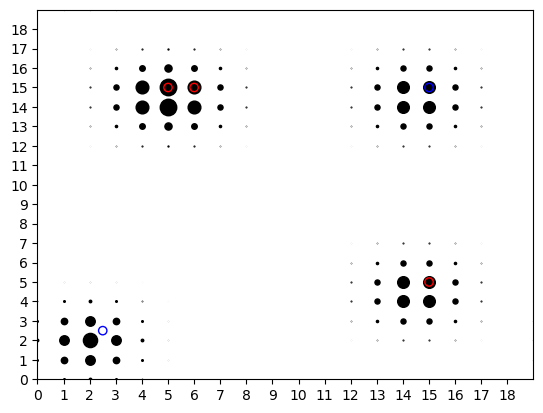

In [156]:

# Get the colormap used in the colorbar
for k1 in range(K1):
    for k2 in range(K2):
        if Q_mine[k1,k2] < 0:
            c = 'b'
        else:
            c = 'r'
        plt.scatter(k1,k2, s = 400*np.abs(Q_mine[k1,k2]), c = 'k')

colors = {-1 : 'b', 1 : 'r'}
for i in range(len(charges)):
    nearest_grid = np.round(u[i])
    # plt.scatter(nearest_grid[0],nearest_grid[1], c = colors[charges[i]])
    plt.scatter(u[i,0],u[i,1], c = 'none', edgecolor = colors[charges[i]])
plt.xticks(np.arange(0,K1-1))
plt.yticks(np.arange(0,K2-1))
# plt.grid(color = 'k', linewidth = 1)
plt.xlim([0,K1-1])
plt.ylim([0,K2-1])

In [85]:
u

array([[ 2.625,  2.625],
       [15.75 ,  5.25 ],
       [ 5.25 , 15.75 ],
       [15.75 , 15.75 ]])

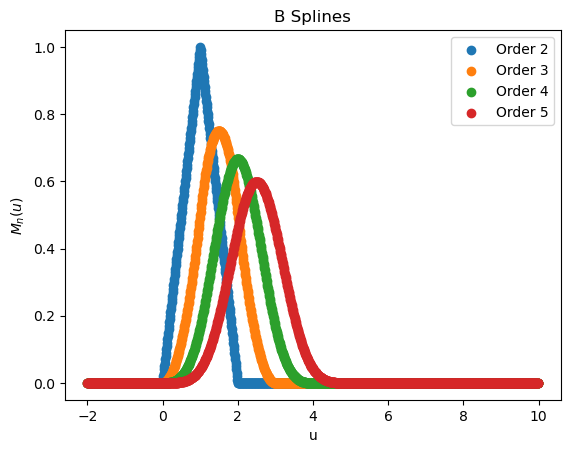

In [16]:
test_u = np.arange(-2,10,0.01)
M2_vals = [M(u_, 2) for u_ in test_u]
M3_vals = [M(u_, 3) for u_ in test_u]
M4_vals = [M(u_, 4) for u_ in test_u]
M5_vals = [M(u_, 5) for u_ in test_u]

plt.scatter(test_u,M2_vals, label = "Order 2")
plt.scatter(test_u,M3_vals, label = "Order 3")
plt.scatter(test_u,M4_vals, label = "Order 4")
plt.scatter(test_u,M5_vals, label = "Order 5")
plt.title("B Splines")
plt.xlabel("u")
plt.ylabel("$M_n(u)$")
plt.legend()

(0.0, 20.0)

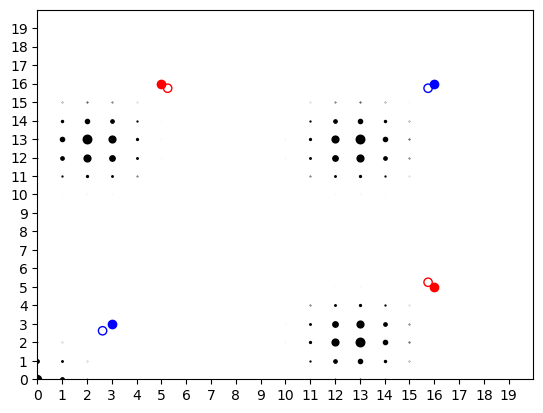

In [18]:

# Brute force (my code)
Q_mine_unshift = np.zeros((K1,K2))
for k1 in range(K1):
    for k2 in range(K2):
        for i in range(len(charges)):
            for n1 in range(K1):
                for n2 in range(K2):
                    Q_mine_unshift[k1,k2] += charges[i]*M(u[i,0] - k1 - n1*K1, n)*M(u[i,1] - k2 - n2*K2,n)


# Get the colormap used in the colorbar
for k1 in range(K1):
    for k2 in range(K2):
        plt.scatter(k1,k2, s = 140*np.abs(Q_mine_unshift[k1,k2]), c = 'k')

colors = {-1 : 'b', 1 : 'r'}
for i in range(len(charges)):
    nearest_grid = np.round(u[i])
    plt.scatter(nearest_grid[0],nearest_grid[1], c = colors[charges[i]])
    plt.scatter(u[i,0],u[i,1], c = 'none', edgecolor = colors[charges[i]])
plt.xticks(np.arange(0,K1-1))
plt.yticks(np.arange(0,K2-1))
# plt.grid(color = 'k', linewidth = 1)
plt.xlim([0,K1-1])
plt.ylim([0,K2-1])